## 0. Setup

In [15]:
import os
### ignore tensorflow warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
#force tensorflow to use CPU only
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [16]:
#download data
from zipfile import ZipFile
#embeddings
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
from huggingface_hub import from_pretrained_keras
from PIL import Image
import numpy as np
import pandas as pd
#timing
from tqdm.auto import tqdm
#vector DB
import kdbai_client as kdbai
from getpass import getpass
import time
#plotting
import umap.umap_ as umap
from matplotlib import pyplot as plt

In [17]:
def show_df(df: pd.DataFrame) -> pd.DataFrame:
    print(df.shape)
    return df.head()

def plot_image(axis, source: str, label=None) -> None:
    axis.imshow(plt.imread(source), cmap = 'gray')
    axis.axis("off")
    title = (f"{label}: " if label else "") + source.split("/")[-1]
    axis.set_title(title)

## 1. Load Image Data

### Define list of paths to the extracted image files

In [18]:
def extract_file_paths_from_folder(parent_dir: str) -> dict:
    image_paths = {}
    for sub_folder in os.listdir(parent_dir):
        sub_dir = os.path.join(parent_dir, sub_folder)
        image_paths[sub_folder] = [
            os.path.join(sub_dir, file) for file in os.listdir(sub_dir)
        ]
    return image_paths

In [19]:
image_paths_map = extract_file_paths_from_folder("COVID-images")

### Visualize Some of the images

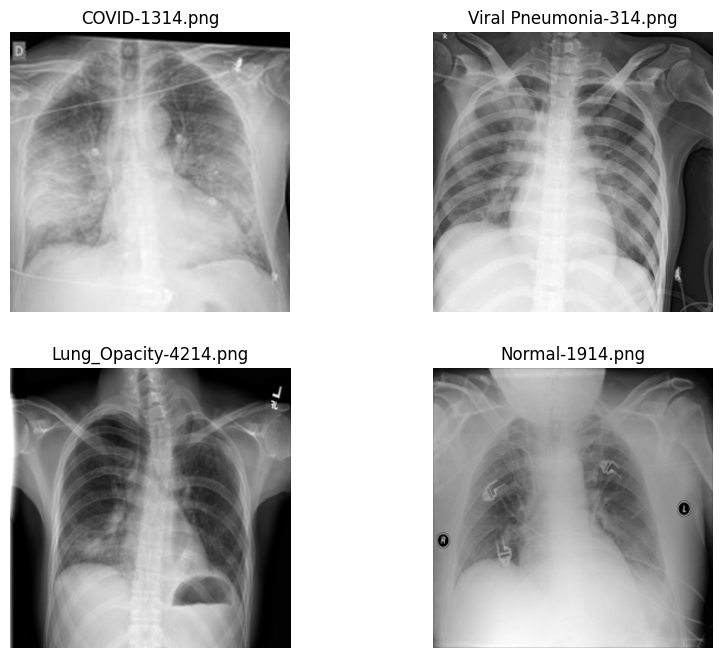

In [20]:
image_index = 14
_, ax = plt.subplots(nrows = len(image_paths_map) // 2, ncols=2, figsize=(10,8))
axes = ax.reshape(-1)
for i, (_, image_paths) in enumerate(image_paths_map.items()):
    for path in image_paths:
        if path.endswith(f"{image_index}.png"):
            break

    plot_image(axes[i], path)

In [21]:
dataset = image_dataset_from_directory(
    "COVID-images",
    labels="inferred",
    label_mode="categorical",
    shuffle=False,
    seed=1,
    image_size=(299,299),
    batch_size=1,
)

Found 6351 files belonging to 4 classes.


## 2. Create Image Vector Embeddings

To create our image embeddings, we will use a neural network which we have pre-trained on the lung classifications. In this showcase, we will use the ResNet-50 nerual network architcture, a popular choice for general image classification.

ResNet-50 was originally trained on the ImageNet dataset - although this dataset contains millions of images, including X-ray scans, we would like it to be a bit more custom suited working with our dataset and the classifications we assign to it. Therefore our model here was ,ade by taking ResNet50, pre-trained on ImageNet, and re-training it to classify X-ray scan images of lungs.

We trained the model using roughly 70% of the Kaggle dataset, split equally among the 4 classifications. We then use the remaining 30% of data in this showcase for embedding as vectors and using to perform image search on.

### Load Pre-Trained classification neural network

In [22]:
model = tf.keras.models.load_model('saved_model/lungs_model.h5')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 305, 305,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 150, 150,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 150, 150,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 150, 150,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 152, 152,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 75, 75,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 75, 75,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 75, 75,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 75, 75,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 75, 75,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 75, 75,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 75, 75,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 75, 75,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 75, 75,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 75, 75,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 75, 75,    │      1,024 │ conv2_block1_3_c

 Total params: 27,784,066 (105.99 MB)

 Trainable params: 27,730,944 (105.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 2 (12.00 B)

### Use embedding network to create image embeddings

In [23]:
embeddings = np.empty([len(dataset), 2048])
labels = np.empty([len(dataset),4])
for i, image in tqdm(enumerate(dataset), total=len(dataset)):
    embeddings[i, :] = model.predict(image[0], verbose=0)
    labels[i, :] = image[1]

  0%|          | 0/6351 [00:00<?, ?it/s]

In [24]:
#sort the disease types in order
lung_types = sorted(image_paths_map.keys())
#for each vector, save the disease type given by the index
class_labels = [lung_types[label.argmax()] for label in labels]
#get a single list of all paths
all_paths = []
for _, image_paths in image_paths_map.items():
    all_paths += image_paths
#sort the source files in alphanumeric order
sorted_all_paths = sorted(all_paths)
#define our DataFrame for insertion into KDB.AI
embedded_df = pd.DataFrame(
    {
        "source": sorted_all_paths,
        "class": class_labels,
        "embedding": embeddings.tolist(),
    }
)

In [25]:
show_df(embedded_df)

(6351, 3)


,source,class,embedding
0,COVID-images/COVID/COVID-1.png,COVID,"[0.1930886059999466, 0.7402693033218384, 0.066..."
1,COVID-images/COVID/COVID-1003.png,COVID,"[0.03127330541610718, 0.014013336971402168, 0...."
2,COVID-images/COVID/COVID-1006.png,COVID,"[0.4907979667186737, 0.06655334681272507, 0.44..."
3,COVID-images/COVID/COVID-1008.png,COVID,"[0.9774723649024963, 0.015101766213774681, 0.0..."
4,COVID-images/COVID/COVID-1013.png,COVID,"[0.32300350069999695, 0.11843094229698181, 0.5..."


### Visualising the embeddings

It is quite difficult to grasp the concept of a high dimensional vector embedding. One trick to help us try and see this is by using UMAP: a technique which reduces the number of dimensions to allow us to visualize the clusterings in 2D. This will allow to us to get an initial grasp of how well classifications have been separated within the embeddings, and also some potential misclassifications that may occur.

In [26]:
_umap = umap.UMAP(n_neighbors=15, min_dist=0.0)
umap_df = pd.DataFrame(_umap.fit_transform(embeddings), columns=["u0", "u1"])
show_df(umap_df)

(6351, 2)


,u0,u1
0,12.448664,13.088075
1,-7.713113,12.488287
2,11.824125,3.567557
3,16.749832,2.685247
4,8.777614,4.108812


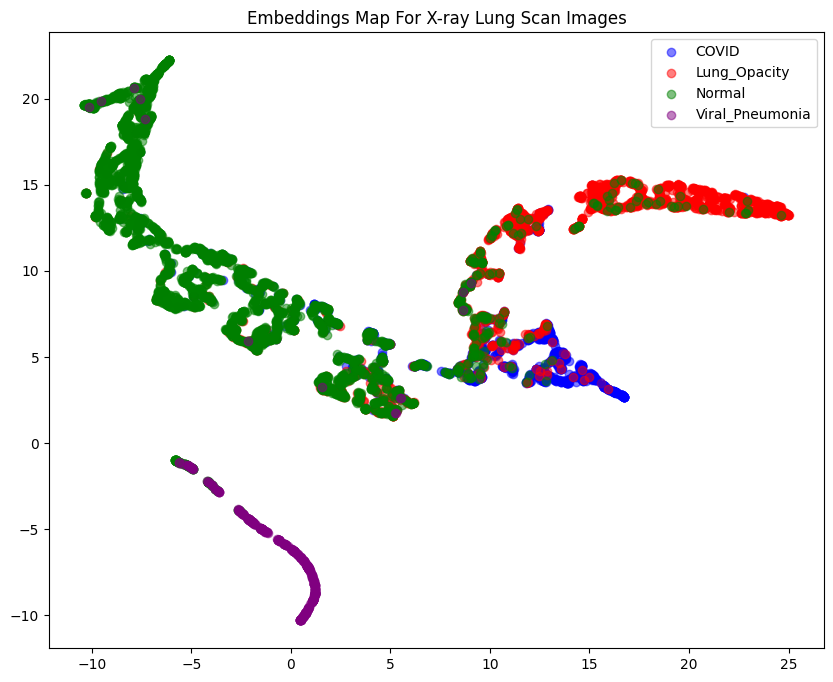

In [27]:
class_colors = ["blue", "red", "green", "purple"]
#Create figure for plotting
plt.figure(figsize=(10, 8))
#Scatter plot with 'u0' and 'u1' columns as x and y, color mapped by class labels
for lung_type, color in zip(lung_types, class_colors):
    indices_to_plot = [i for i, label in enumerate(class_labels) if label == lung_type]
    subset = umap_df.iloc[indices_to_plot]
    plt.scatter(subset["u0"], subset["u1"], label=lung_type, color=color, alpha=0.5)

plt.title("Embeddings Map For X-ray Lung Scan Images")
plt.legend()
plt.show()

## 3. Store Embeddings in KDB.AI

In [28]:
session = kdbai.Session(endpoint="http://localhost:8082")
image_schema = {
    "columns": [
        {"name": "source", "pytype": "str"},
        {"name": "class", "pytype": "str"},
        {
            "name": "embedding",
            "vectorIndex": {"dims":2048, "metric":"IP", "type": "flat"},
        },
    ]
}

In [29]:
try:
    session.table("lungs").drop()
    time.sleep(5)
except kdbai.KDBAIException:
    pass

In [30]:
table = session.create_table("lungs", image_schema)

In [31]:
embedded_df.memory_usage(deep=True).sum() / (1024**2)

100.59794807434082

In [32]:
#Yield successive n-sized chunks from l
def divide_chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]
#How many elements each list should have
n = len(embedded_df) // 12
#Now split the data 
embedded_df_split = list(divide_chunks(embedded_df, n))
#and insert the now acceptably sized chunks
for i in tqdm(range(len(embedded_df_split))):
    table.insert(embedded_df_split[i])

  0%|          | 0/13 [00:00<?, ?it/s]

In [33]:
session.list()

['lungs_l2_hnsw',
 'newtable',
 'ai_tools',
 'reports',
 'rag_langchain',
 'pdf',
 'policy_pdf',
 'lungs']

## 4. Query KDB.AI Table

In [34]:
table.query()

,source,class,embedding
0,COVID-images/COVID/COVID-1.png,COVID,"[0.1930886059999466, 0.7402693033218384, 0.066..."
1,COVID-images/COVID/COVID-1003.png,COVID,"[0.03127330541610718, 0.014013336971402168, 0...."
2,COVID-images/COVID/COVID-1006.png,COVID,"[0.4907979667186737, 0.06655334681272507, 0.44..."
3,COVID-images/COVID/COVID-1008.png,COVID,"[0.9774723649024963, 0.015101766213774681, 0.0..."
4,COVID-images/COVID/COVID-1013.png,COVID,"[0.32300350069999695, 0.11843094229698181, 0.5..."
...,...,...,...
6346,COVID-images/Viral_Pneumonia/Viral Pneumonia-9...,Viral_Pneumonia,"[1.4559446753992233e-05, 1.8509032088331878e-0..."
6347,COVID-images/Viral_Pneumonia/Viral Pneumonia-9...,Viral_Pneumonia,"[4.3969259422738105e-05, 1.5448327758349478e-0..."
6348,COVID-images/Viral_Pneumonia/Viral Pneumonia-9...,Viral_Pneumonia,"[0.009182139299809933, 0.0017427902203053236, ..."
6349,COVID-images/Viral_Pneumonia/Viral Pneumonia-9...,Viral_Pneumonia,"[2.2270078261499293e-05, 0.0003343209391459822..."


In [35]:
table.query(filter=[("like", "class", "*Lung*")])

,source,class,embedding
0,COVID-images/Lung_Opacity/Lung_Opacity-1.png,Lung_Opacity,"[0.11273650079965591, 0.42313218116760254, 0.4..."
1,COVID-images/Lung_Opacity/Lung_Opacity-10.png,Lung_Opacity,"[0.17577897012233734, 0.7366110682487488, 0.08..."
2,COVID-images/Lung_Opacity/Lung_Opacity-1009.png,Lung_Opacity,"[0.04618028178811073, 0.7661265730857849, 0.18..."
3,COVID-images/Lung_Opacity/Lung_Opacity-101.png,Lung_Opacity,"[0.053287386894226074, 0.9310305118560791, 0.0..."
4,COVID-images/Lung_Opacity/Lung_Opacity-1013.png,Lung_Opacity,"[0.10065077245235443, 0.7487967014312744, 0.15..."
...,...,...,...
1799,COVID-images/Lung_Opacity/Lung_Opacity-984.png,Lung_Opacity,"[0.004457301925867796, 0.9920989274978638, 0.0..."
1800,COVID-images/Lung_Opacity/Lung_Opacity-985.png,Lung_Opacity,"[0.0596608929336071, 0.6163009405136108, 0.324..."
1801,COVID-images/Lung_Opacity/Lung_Opacity-986.png,Lung_Opacity,"[0.06715655326843262, 0.8165585398674011, 0.11..."
1802,COVID-images/Lung_Opacity/Lung_Opacity-994.png,Lung_Opacity,"[0.00641989940777421, 0.9740433096885681, 0.01..."


## 5. Search for similar images to a target image

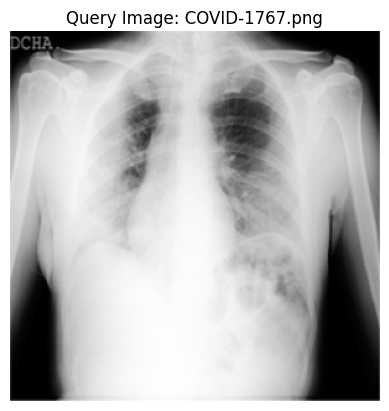

In [36]:
#Get a sample row
row_index_1 = 240
#Select the random row and the desired colimn's value
row_1 = embedded_df.iloc[row_index_1]
plot_image(plt.subplots()[-1], row_1["source"], label="Query Image")

In [37]:
sample_embedding_1 = row_1["embedding"]
#we use the search function to find the 8 nearest neighbours
results_1 = table.search([sample_embedding_1], n=9)
results_1[0]

,source,class,embedding,__nn_distance
0,COVID-images/COVID/COVID-389.png,COVID,"[0.9950439929962158, 0.0033893492072820663, 0....",0.424392
1,COVID-images/COVID/COVID-302.png,COVID,"[0.9872400164604187, 0.009812476113438606, 0.0...",0.423827
2,COVID-images/COVID/COVID-552.png,COVID,"[0.988183856010437, 0.0077135334722697735, 0.0...",0.423636
3,COVID-images/COVID/COVID-741.png,COVID,"[0.9690572023391724, 0.028436996042728424, 0.0...",0.423190
4,COVID-images/COVID/COVID-1405.png,COVID,"[0.9652830362319946, 0.03201880678534508, 0.00...",0.422988
5,COVID-images/COVID/COVID-387.png,COVID,"[0.9816957712173462, 0.011743752285838127, 0.0...",0.422897
6,COVID-images/COVID/COVID-1008.png,COVID,"[0.9774723649024963, 0.015101766213774681, 0.0...",0.422563
7,COVID-images/COVID/COVID-595.png,COVID,"[0.9734203815460205, 0.01869882270693779, 0.00...",0.422316
8,COVID-images/COVID/COVID-283.png,COVID,"[0.9874628186225891, 0.001264440594241023, 0.0...",0.422193


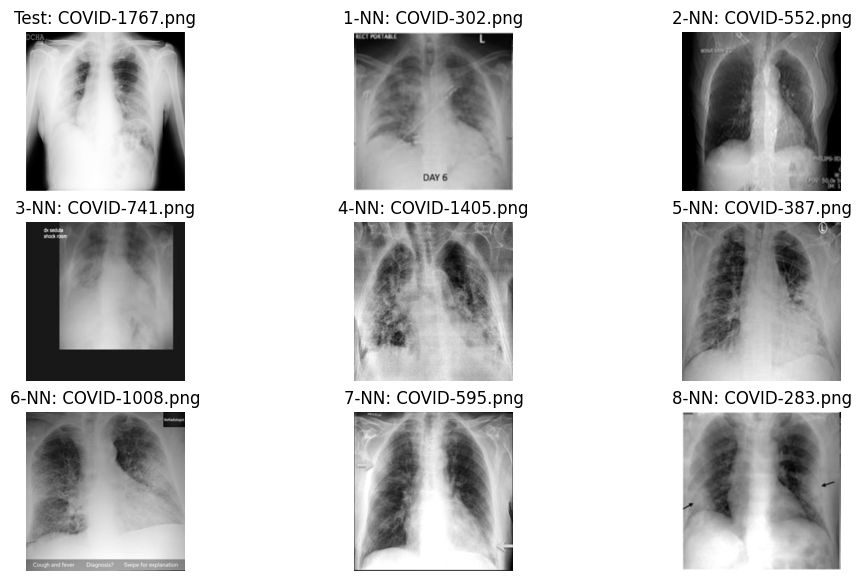

In [38]:
#create function for displaying our query image along with its nearest neighbours
def plot_test_result_with_8NN(test_file: str, neighbors: pd.Series) -> None:
    #create figure
    _, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,7))
    axes = ax.reshape(-1)
    #plot query image
    plot_image(axes[0], test_file, "Test")
    #plot nearest neighbors
    for i, (_, value) in enumerate(neighbors.items(), start = 1):
        plot_image(axes[i], value, f"{i}-NN")

nn1_filenames = results_1[0][1:]["source"]
plot_test_result_with_8NN(row_1["source"], nn1_filenames)

5699


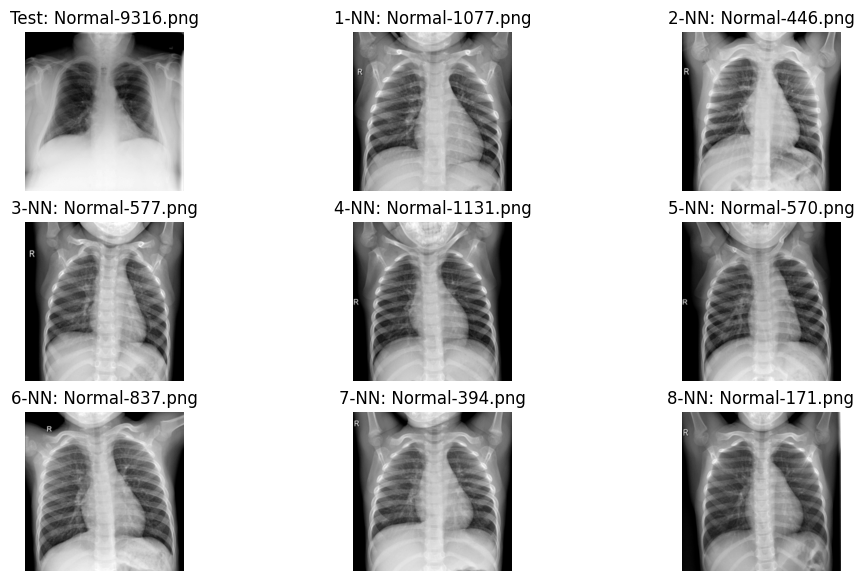

In [43]:
#Automate the search process
def lung_image_nn_search(table, df:pd.DataFrame, row_index: int) -> None:
    #Select randow row and desired column's value
    row = df.iloc[row_index]
    #get embedding from this row
    row_embedding = row["embedding"]
    #Search for 8 nearest neighbors (excluding self)
    nn_results = table.search([row_embedding], n=9)[0][1:]
    #plot the neighbors
    plot_test_result_with_8NN(row["source"], nn_results["source"])
#get another row
random_row_index = np.random.randint(0,len(embedded_df))
print(random_row_index)
lung_image_nn_search(table, embedded_df, random_row_index)

In [40]:
def accuracy_measure (table, df: pd.DataFrame) -> None: 
    full_accuracy = 0 
    for i in tqdm(range(6351)):
        row = df.iloc[i] 
        embed = row["embedding"] 
        neighbors = table.search([embed],n=18)[0][1::2] 
        accuracy = 0 
        for j,category in enumerate(neighbors["class"]): 
            if category == row["class"]: 
                accuracy += (8-j) 
        accuracy = accuracy/36 
        full_accuracy += accuracy 
    full_accuracy = full_accuracy/6351 
    print(full_accuracy) 

In [41]:
accuracy_measure(table, embedded_df)

  0%|          | 0/6351 [00:00<?, ?it/s]

0.80396350530975


In [ ]:
#delete table when done
table.drop()